In [ ]:
install.packages("tidyverse")
install.packages("tsibble")
install.packages("fable")
install.packages("fabletools")
install.packages("feasts")
install.packages("lubridate")
install.packages("scales")
install.packages("fpp3")
install.packages("gridExtra")
install.packages("tsibble")
install.packages("urca")
install.packages("zoo")


suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))
suppressMessages(library(urca))
suppressMessages(library(zoo))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggplot2’, ‘quadprog’, ‘progressr’, ‘ggdist’, ‘numDeriv’, ‘fabletools’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘tsibbledata’


Installing package into ‘/usr/local/lib/R/site-library

###Loading and extracting county and states

In [ ]:
data <- read.csv('monthly_housing_inventory.csv')
data |> head(10)

data <-  data %>%
mutate(county = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=1)) %>%
mutate(state = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=2)) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m'))

data %>% head()

,month_date_yyyymm,county_name,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,202403,"hartley, tx",425000,12,0,1,289,3024,444336,12
2,202403,"rock, mn",309900,21,8,13,136,2016,397205,35
3,202403,"carter, ok",199000,165,56,59,127,1633,306719,222
4,202403,"mckean, pa",169000,48,12,25,89,1898,187270,71
5,202403,"etowah, al",248950,236,128,67,124,1894,296370,303
6,202403,"dawson, ga",679450,135,76,80,227,2802,814852,211
7,202403,"middlesex, ct",559900,194,152,219,250,2098,700510,418
8,202403,"garfield, co",1272500,148,68,92,503,2536,1904972,240
9,202403,"jefferson, ny",235000,187,96,152,141,1697,358984,330


,month_date_yyyymm,county_name,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count,county,state,month_date
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<mth>
1,202403,"hartley, tx",425000,12,0,1,289,3024,444336,12,hartley,tx,2024 Mar
2,202403,"rock, mn",309900,21,8,13,136,2016,397205,35,rock,mn,2024 Mar
3,202403,"carter, ok",199000,165,56,59,127,1633,306719,222,carter,ok,2024 Mar
4,202403,"mckean, pa",169000,48,12,25,89,1898,187270,71,mckean,pa,2024 Mar
5,202403,"etowah, al",248950,236,128,67,124,1894,296370,303,etowah,al,2024 Mar
6,202403,"dawson, ga",679450,135,76,80,227,2802,814852,211,dawson,ga,2024 Mar


###Filter out the five states data from the whole dataset

In [ ]:
# If doing option 3 you may want to filter the data ahead of time to reduce the processing
df_five_states <- data %>% filter(state %in% c('md', 'va', 'pa', 'de', 'nj'))
df_five_states %>% dim()



df_five_states_ts <- df_five_states %>% as_tsibble(index=month_date, key=c(state, county))




df_five_states_ts <- df_five_states_ts %>%
fill_gaps()

df_five_states_ts %>% head()

df_five_states_ts %>% dim()




df_five_states_ts_filled <- df_five_states_ts |>
  model(ARIMA(active_listing_count ~ pdq(0:1, 0:1, 0:1) + PDQ(0,0,0))) |>
  fabletools::interpolate(df_five_states_ts)

df_five_states_ts_filled %>% head()




df_five_states_ts_filled %>% filter(is.na(active_listing_count))





df_states_ts <- df_five_states_ts_filled %>%
fabletools::aggregate_key(
    state,
    total_listing=sum(active_listing_count)
)



df_states_ts %>% head()



df_states_ts %>% scan_gaps()

df_states_ts <- df_states_ts %>% filter(state!="<aggregated>")
states_training <- df_states_ts %>% filter_index(. ~ '2022 Dec')
states_test <- df_states_ts %>% filter_index('2023 Jan' ~ .)

[1] 22674    13

month_date_yyyymm,county_name,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count,county,state,month_date
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<mth>
201607,"kent, de",240000,1203,332,412,119,1916,248196,1596,kent,de,2016 Jul
201608,"kent, de",238925,1202,282,389,118,1911,244720,1588,kent,de,2016 Aug
201609,"kent, de",239000,1192,362,278,119,1898,245363,1461,kent,de,2016 Sep
201610,"kent, de",239700,1184,272,410,119,1909,247105,1603,kent,de,2016 Oct
201611,"kent, de",238600,1160,274,382,119,1909,245420,1544,kent,de,2016 Nov
201612,"kent, de",235780,1099,184,346,118,1897,241322,1443,kent,de,2016 Dec


[1] 22802    13

state,county,month_date,active_listing_count
<chr>,<chr>,<mth>,<dbl>
de,kent,2016 Jul,1203
de,kent,2016 Aug,1202
de,kent,2016 Sep,1192
de,kent,2016 Oct,1184
de,kent,2016 Nov,1160
de,kent,2016 Dec,1099


state,county,month_date,active_listing_count
<chr>,<chr>,<mth>,<dbl>


month_date,state,total_listing
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,196832
2016 Aug,<aggregated>,193834
2016 Sep,<aggregated>,190681
2016 Oct,<aggregated>,186352
2016 Nov,<aggregated>,175776
2016 Dec,<aggregated>,159476


state,month_date
<chr*>,<mth>


Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


I aggregated the data by states, so I can forecasts for individual states.
CHecked for gaps and filled them using interpolate and ARIMA model, also split split the data into training and testing.

In [ ]:
df_fab5_ts <- df_five_states_ts_filled %>%
fabletools::aggregate_key(
    state / county,
    total_listing=sum(active_listing_count)
)

df_fab5_ts %>% dim()

[1] 23360     4

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


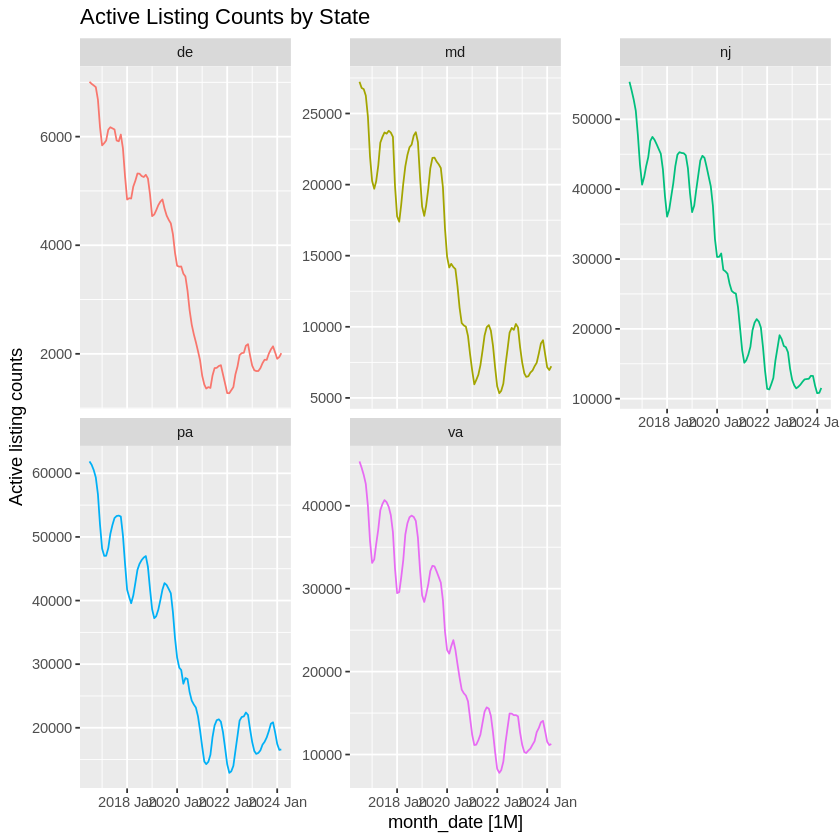

In [ ]:
df_fab5_ts |>
  filter(state != "<aggregated>") |>
  filter(is_aggregated(county)) |>
  autoplot(total_listing) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts by State") +
  facet_wrap(vars(state), scales = "free_y", ncol = 3) +
  theme(legend.position = "none")

This is the individual plot for each of five states after removing the aggregated data.

In [ ]:
library(dplyr)


# Filter out only state data
state_data <- df_fab5_ts %>%
  filter(state != "<aggregated>")

# Display the filtered state data
head(state_data)

md_data <- state_data %>%
  filter(state == "md")
va_data <- state_data %>%
  filter(state == "va")
pa_data <- state_data %>%
  filter(state == "pa")
de_data <- state_data %>%
  filter(state == "de")
nj_data <- state_data %>%
  filter(state == "nj")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,de,<aggregated>,7010
2016 Jul,md,<aggregated>,27232
2016 Jul,nj,<aggregated>,55374
2016 Jul,pa,<aggregated>,61872
2016 Jul,va,<aggregated>,45344
2016 Aug,de,<aggregated>,6972


For each month, here is the dataset for each of the states, with the active listing count summed for counties.

##Forecasts for Maryland

In [ ]:
head(md_data)

month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,md,<aggregated>,27232
2016 Aug,md,<aggregated>,26799
2016 Sep,md,<aggregated>,26715
2016 Oct,md,<aggregated>,26258
2016 Nov,md,<aggregated>,24768
2016 Dec,md,<aggregated>,22002


In [ ]:
aggregated_md_data <- md_data %>%
fabletools::aggregate_key(
    state,
    total_listing_md=sum(total_listing)
)

aggregated_md_data %>% dim()

[1] 186   3

In [ ]:
aggregated_md_data %>% head()

month_date,state,total_listing_md
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,54464
2016 Aug,<aggregated>,53598
2016 Sep,<aggregated>,53430
2016 Oct,<aggregated>,52516
2016 Nov,<aggregated>,49536
2016 Dec,<aggregated>,44004


In [ ]:
library(dplyr)

# Filter out rows where county is "<aggregated>"
aggregated_md_data <- aggregated_md_data %>%
  filter(state != "<aggregated>")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


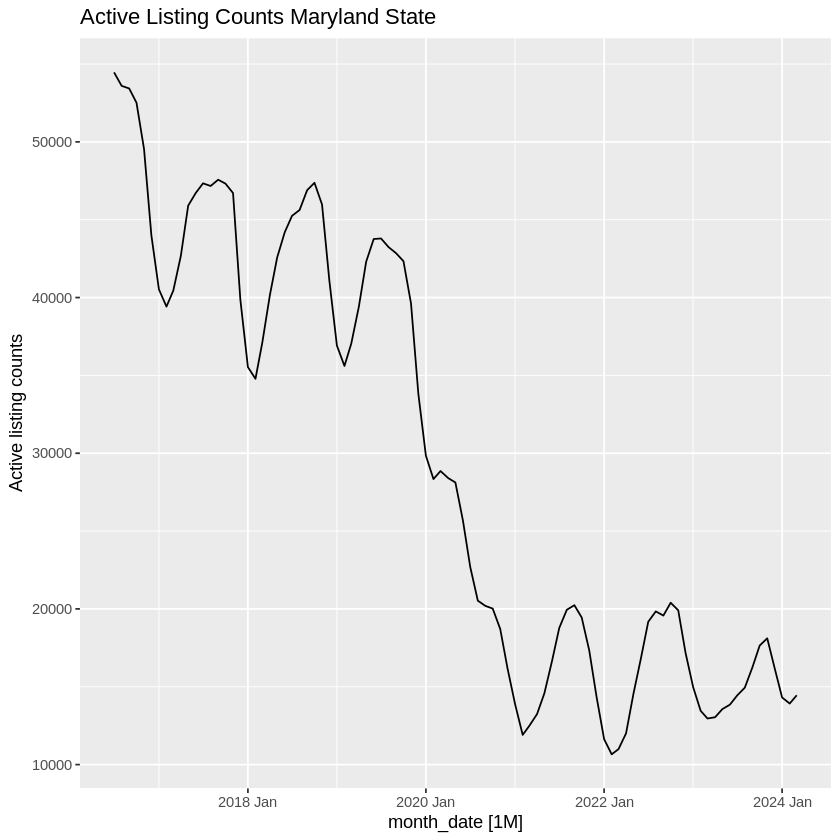

In [ ]:
aggregated_md_data |>
  autoplot(total_listing_md) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts Maryland State")

Plot for Maryland state, the trend is decreasing from 2019 to 2021, and then on it is increasing. There is clearly seasonality in the graphs

In [ ]:
# Split data: training and testing
split_date <- as.Date("2022-12-01")
training_set_md <- aggregated_md_data %>% filter(month_date <= split_date)
testing_set_md <- aggregated_md_data %>% filter(month_date > split_date)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date <= split_date`.
Caused by warning:
! Incompatible methods ("<=.vctrs_vctr", "<=.Date") for "<="”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date > split_date`.
Caused by warning:
! Incompatible methods (">.vctrs_vctr", ">.Date") for ">"”


In [ ]:
# Fit models
models_md <- training_set_md %>%
  model(
    ARIMA = ARIMA(total_listing_md),
    ETS = ETS(total_listing_md),
    NAIVE = NAIVE(total_listing_md)
  )

In [ ]:
models_md |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,883.5645,2.785318
ETS,1037.3064,3.463531
NAIVE,2244.5827,6.624438


From the MAPE and RMSE scores, ARIMA performs best on the training data

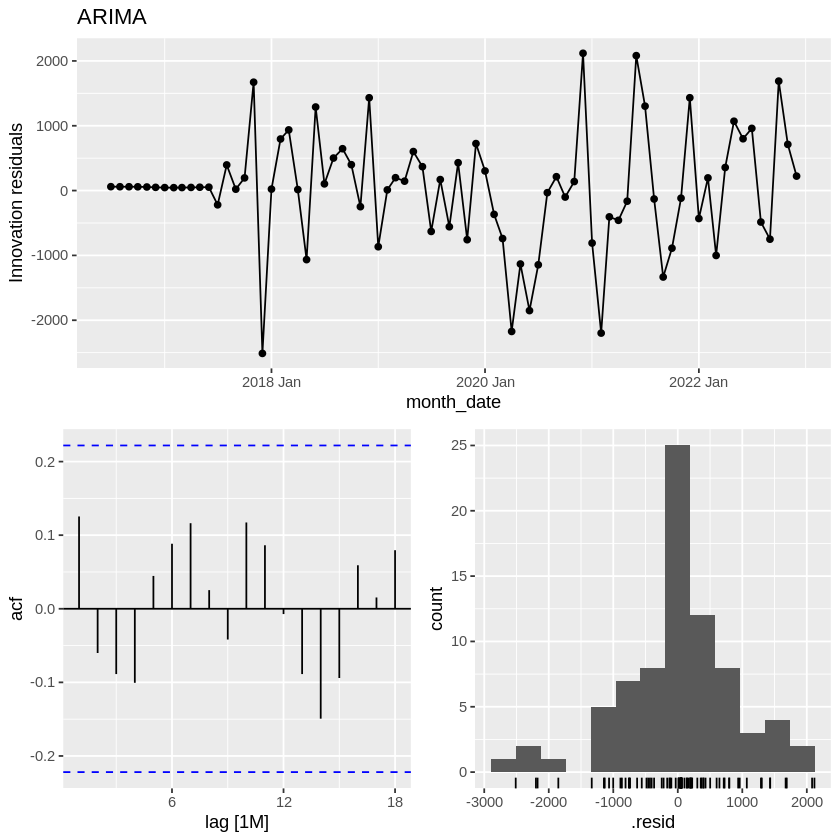

In [ ]:
models_md %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

The residuals looks fine, with not much patterns in the acf plots.

In [ ]:
md_fcst <- models_md |>
forecast(testing_set_md)

md_fcst |> accuracy(testing_set_md) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,4552.876,22.40922
ETS,5394.558,30.93497
NAIVE,2817.013,18.17258


Naive model has less error scores out of others.

ARIMA performs well on training set and Naive performs well on the testing set.

So, I chose Naive to model further as it performs well on the testing data and would likely perform best on the future data.

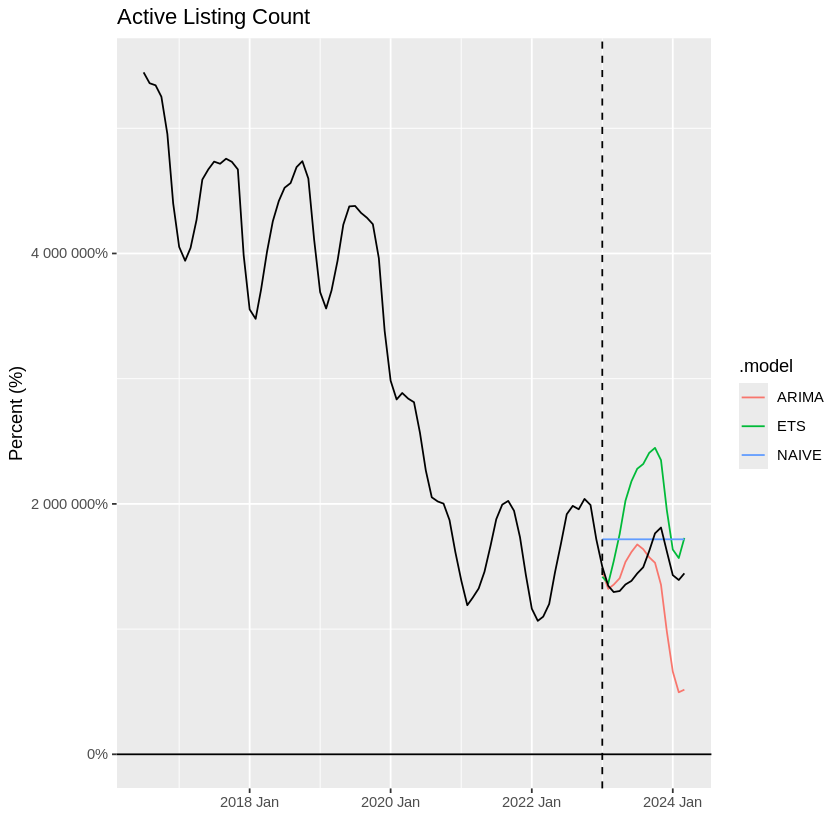

In [ ]:
md_fcst |> autoplot(level=NULL) +
autolayer(aggregated_md_data, total_listing_md) +
labs(title='Active Listing Count', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

Looking at the graph, the Naive is almost close to original although does not fit perfectly.

###Future Forecasts

In [ ]:
md_fnl <- aggregated_md_data |>
model(
    'NAIVE' = NAIVE(total_listing_md)
)

md_fnl %>% report()

Series: total_listing_md 
Model: NAIVE 

sigma^2: 4290290.2341 


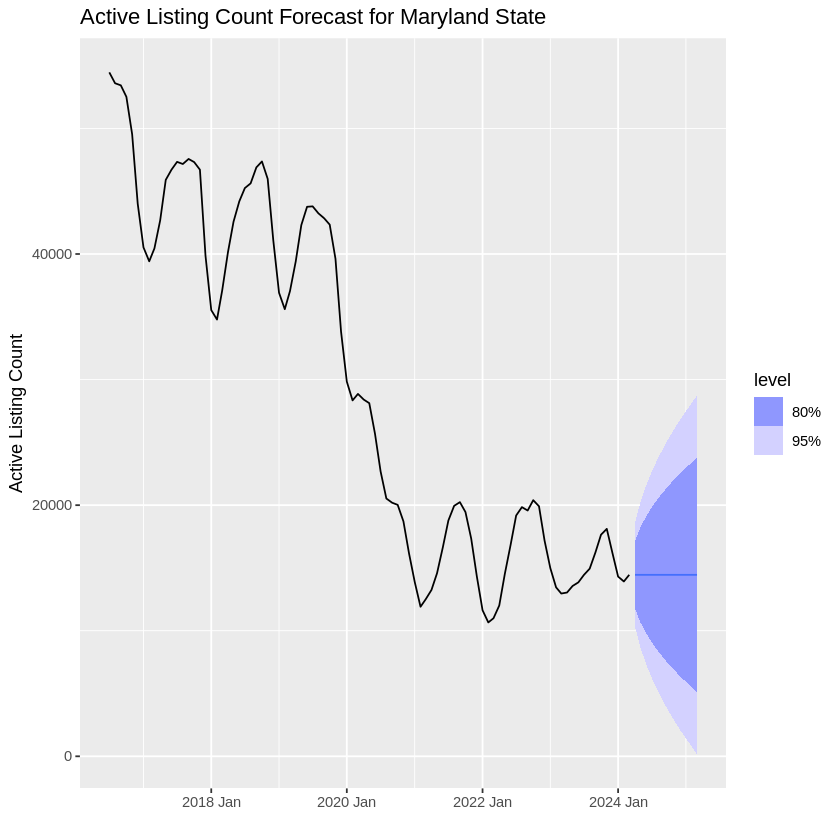

In [ ]:
md_fnl |> forecast(h=12) |>
autoplot() +
autolayer(aggregated_md_data, total_listing_md) +
labs(title='Active Listing Count Forecast for Maryland State', x='', y='Active Listing Count')

The future forecasts looks promising as the possibility of the values falling in the shown confidence interval is likely.

##Forecast for Virginia

In [ ]:
head(va_data)

month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,va,<aggregated>,45344
2016 Aug,va,<aggregated>,44582
2016 Sep,va,<aggregated>,43712
2016 Oct,va,<aggregated>,42624
2016 Nov,va,<aggregated>,39957
2016 Dec,va,<aggregated>,35818


In [ ]:
aggregated_va_data <- va_data %>%
fabletools::aggregate_key(
    state,
    total_listing_va=sum(total_listing)
)

aggregated_va_data %>% dim()

[1] 186   3

In [ ]:
aggregated_va_data %>% head()

month_date,state,total_listing_va
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,90688
2016 Aug,<aggregated>,89164
2016 Sep,<aggregated>,87424
2016 Oct,<aggregated>,85248
2016 Nov,<aggregated>,79914
2016 Dec,<aggregated>,71636


In [ ]:
library(dplyr)

# Filter out rows where county is "<aggregated>"
aggregated_va_data <- aggregated_va_data %>%
  filter(state != "<aggregated>")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


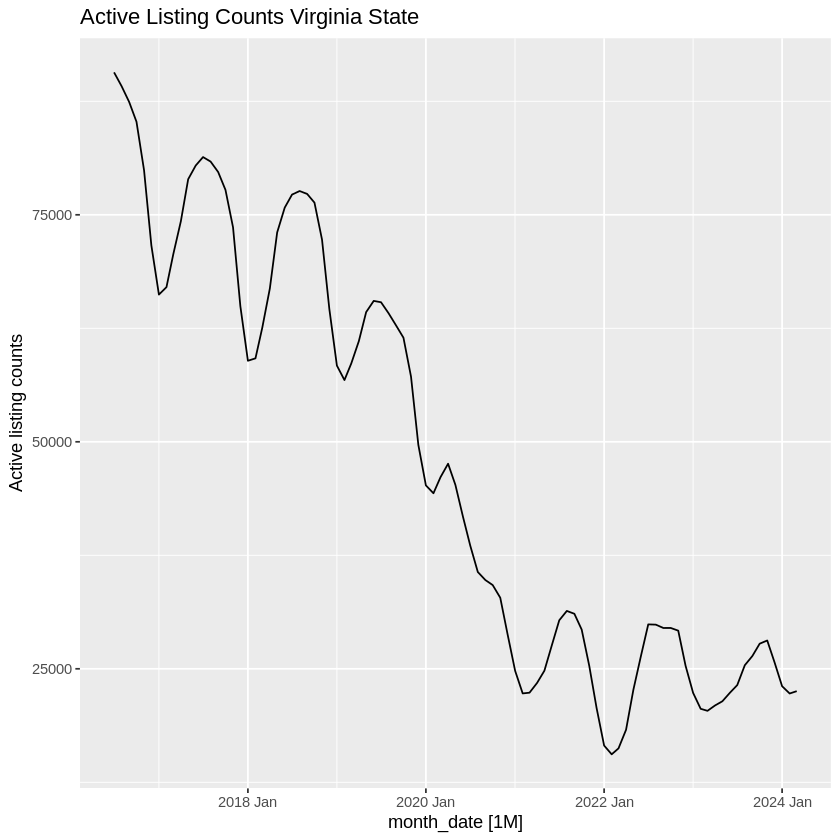

In [ ]:
aggregated_va_data |>
  autoplot(total_listing_va) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts Virginia State")

The trend is decreasing similarly to that of Maryland and has seasonality in it.

In [ ]:
# Split data: training and testing
split_date <- as.Date("2022-12-01")
training_set_va <- aggregated_va_data %>% filter(month_date <= split_date)
testing_set_va <- aggregated_va_data %>% filter(month_date > split_date)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date <= split_date`.
Caused by warning:
! Incompatible methods ("<=.vctrs_vctr", "<=.Date") for "<="”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date > split_date`.
Caused by warning:
! Incompatible methods (">.vctrs_vctr", ">.Date") for ">"”


In [ ]:
# Fit models
models_va <- training_set_va %>%
  model(
    ARIMA = ARIMA(total_listing_va),
    ETS = ETS(total_listing_va),
    NAIVE = NAIVE(total_listing_va)
  )

models_va |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,1036.102,2.117894
ETS,1598.267,3.254986
NAIVE,3352.477,6.165440


ARIMA performs well according to the errors.

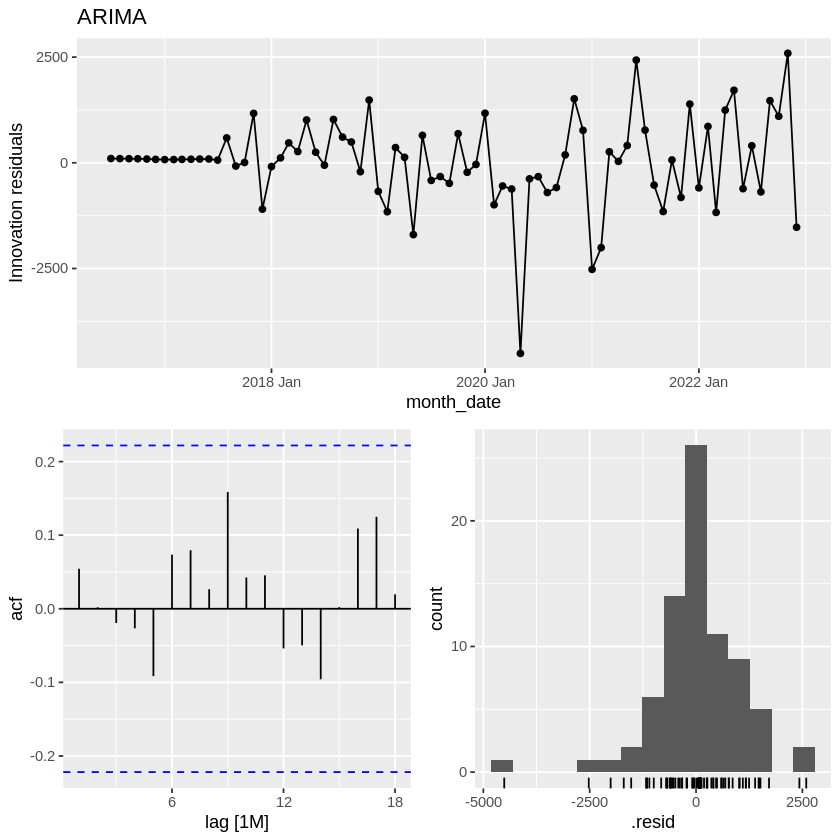

In [ ]:
models_va %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

The residuals looks good too, with no real pattern in acf plots.

In [ ]:
va_fcst <- models_va |>
forecast(testing_set_va)

va_fcst |> accuracy(testing_set_va) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,8819.108,28.47173
ETS,8872.994,33.16598
NAIVE,3069.868,12.18663


Similar to the case we saw for Maryland, Naive performs on testing set

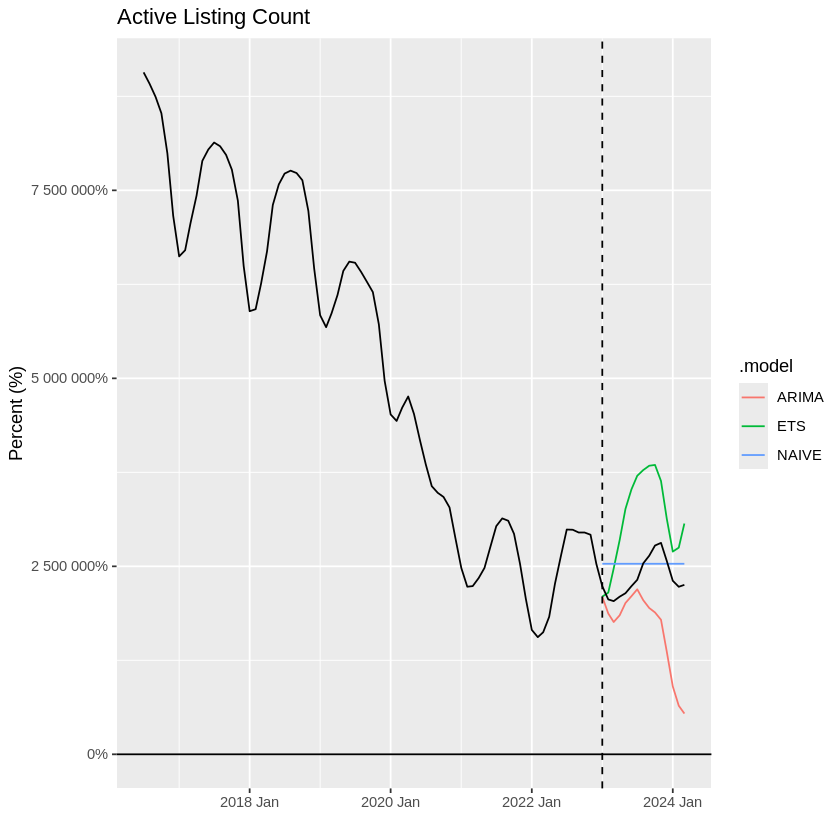

In [ ]:
va_fcst |> autoplot(level=NULL) +
autolayer(aggregated_va_data, total_listing_va) +
labs(title='Active Listing Count', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

Naive captures well according to the graph.

###Future forecasts

In [ ]:
va_fnl <- aggregated_va_data |>
model(
    'NAIVE' = NAIVE(total_listing_va)
)

va_fnl %>% report()

Series: total_listing_va 
Model: NAIVE 

sigma^2: 9344799.0601 


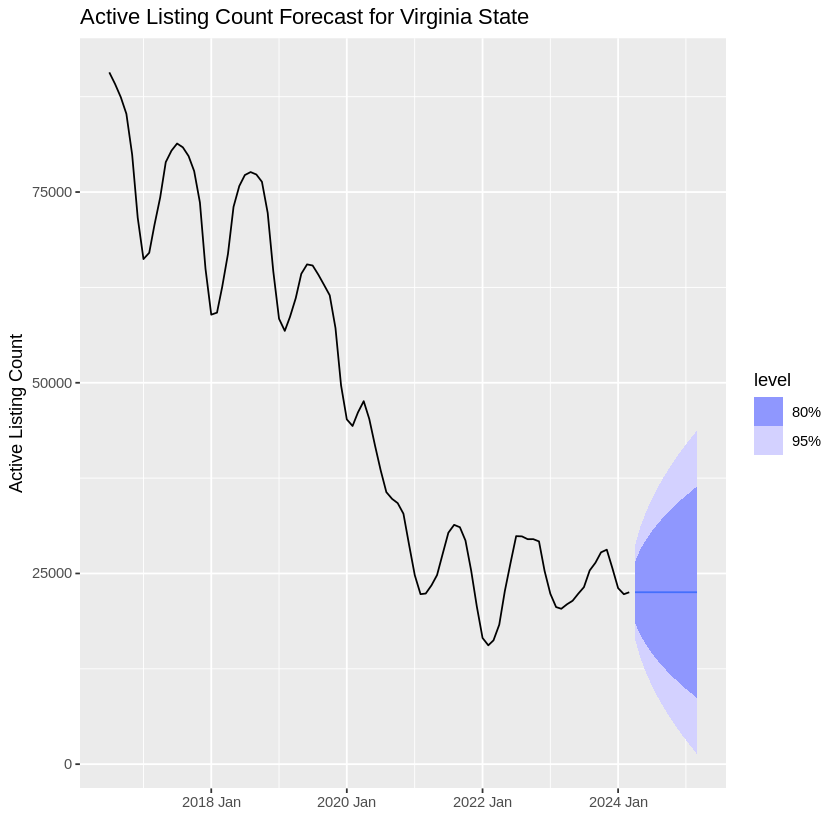

In [ ]:
va_fnl |> forecast(h=12) |>
autoplot() +
autolayer(aggregated_va_data, total_listing_va) +
labs(title='Active Listing Count Forecast for Virginia State', x='', y='Active Listing Count')

The interval looks likely according to the confidence interval.

##For Pennsylvania

In [ ]:
head(pa_data)

month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,pa,<aggregated>,61872
2016 Aug,pa,<aggregated>,61343
2016 Sep,pa,<aggregated>,60502
2016 Oct,pa,<aggregated>,59346
2016 Nov,pa,<aggregated>,56691
2016 Dec,pa,<aggregated>,51961


In [ ]:
aggregated_pa_data <- pa_data %>%
fabletools::aggregate_key(
    state,
    total_listing_pa=sum(total_listing)
)

aggregated_pa_data %>% dim()

[1] 186   3

In [ ]:
aggregated_pa_data %>% head()

month_date,state,total_listing_pa
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,123744
2016 Aug,<aggregated>,122686
2016 Sep,<aggregated>,121004
2016 Oct,<aggregated>,118692
2016 Nov,<aggregated>,113382
2016 Dec,<aggregated>,103922


In [ ]:
library(dplyr)

# Filter out rows where county is "<aggregated>"
aggregated_pa_data <- aggregated_pa_data %>%
  filter(state != "<aggregated>")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


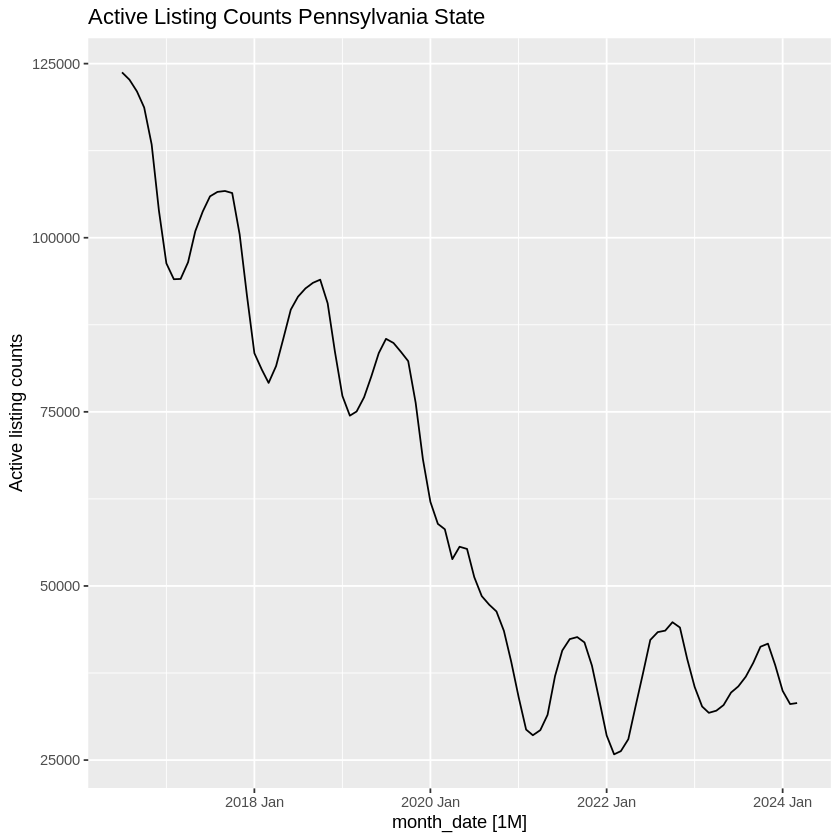

In [ ]:
aggregated_pa_data |>
  autoplot(total_listing_pa) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts Pennsylvania State")

Similar to the above states, it has decreasing trend and yearly seasonality in it.

In [ ]:
# Split data: training and testing
split_date <- as.Date("2022-12-01")
training_set_pa <- aggregated_pa_data %>% filter(month_date <= split_date)
testing_set_pa <- aggregated_pa_data %>% filter(month_date > split_date)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date <= split_date`.
Caused by warning:
! Incompatible methods ("<=.vctrs_vctr", "<=.Date") for "<="”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date > split_date`.
Caused by warning:
! Incompatible methods (">.vctrs_vctr", ">.Date") for ">"”


In [ ]:
# Fit models
models_pa <- training_set_pa %>%
  model(
    ARIMA = ARIMA(total_listing_pa),
    ETS = ETS(total_listing_pa),
    NAIVE = NAIVE(total_listing_pa)
  )

models_pa |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,1442.814,2.028322
ETS,1452.443,1.957435
NAIVE,3767.456,5.252145


ETS performs well on training set

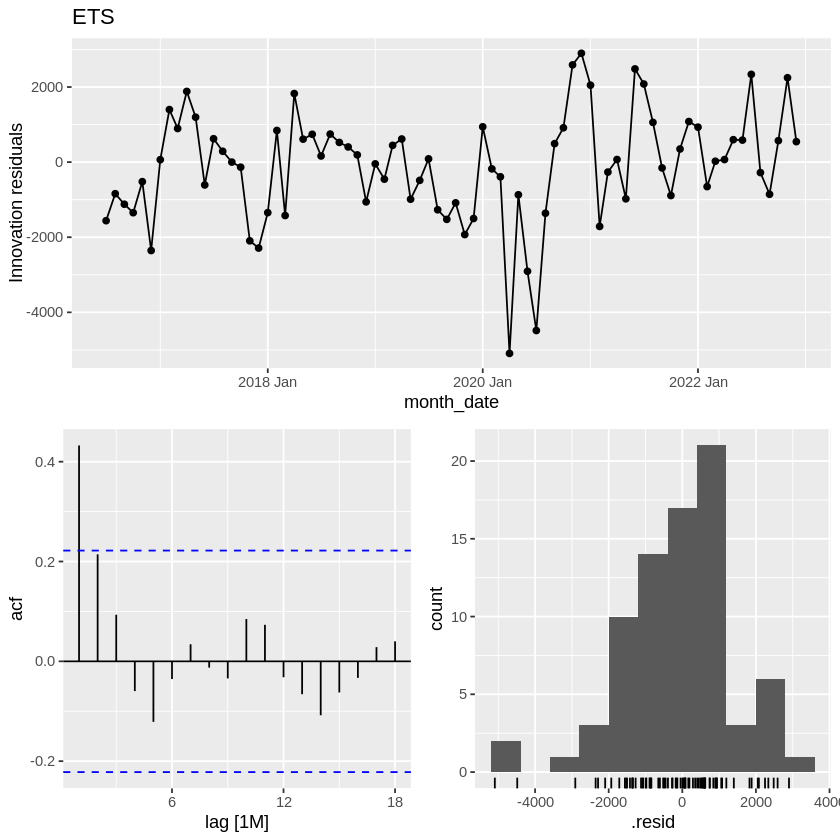

In [ ]:
models_pa %>% select(ETS) %>% gg_tsresiduals() + labs(title='ETS')

The residuals look good and the spike at lag 1 is because of the annual seasonality.

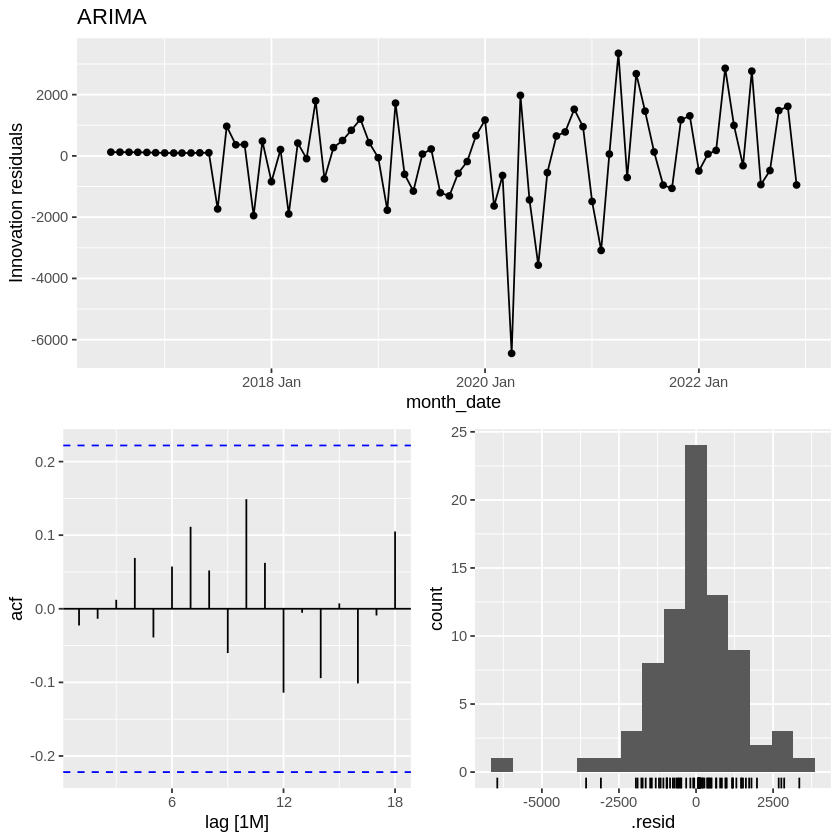

In [ ]:
models_pa %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

In [ ]:
pa_fcst <- models_pa |>
forecast(testing_set_pa)

pa_fcst |> accuracy(testing_set_pa) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,4936.519,9.38575
ETS,8046.889,18.76447
NAIVE,5040.283,13.15297


But, ARIMA performs well on testing data.

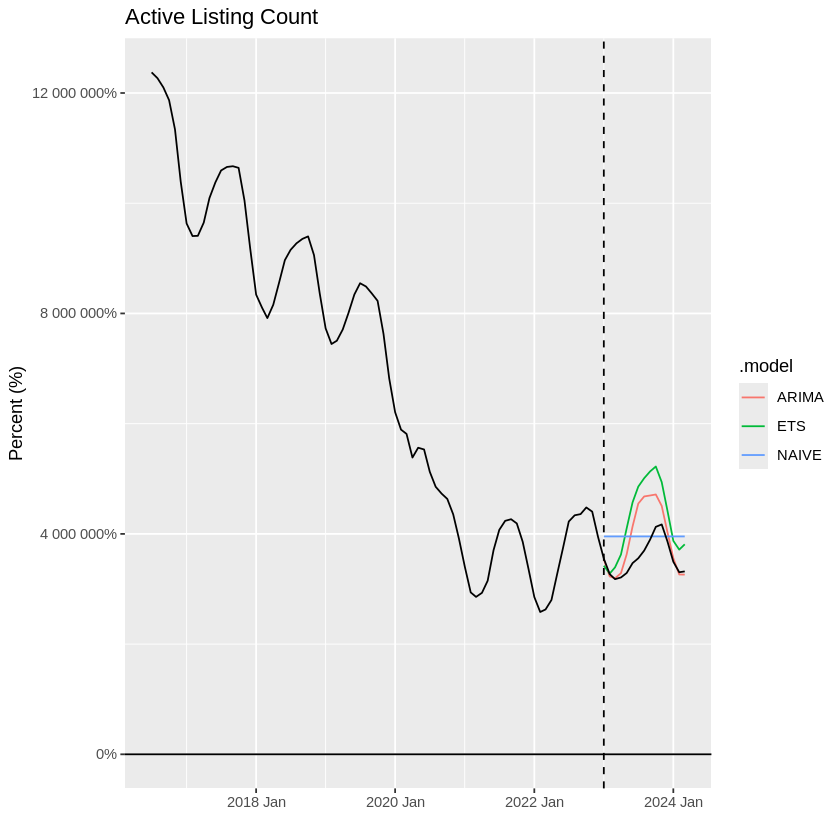

In [ ]:
pa_fcst |> autoplot(level=NULL) +
autolayer(aggregated_pa_data, total_listing_pa) +
labs(title='Active Listing Count', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

###Future forecasts

In [ ]:
pa_fnl <- aggregated_pa_data |>
model(
    'ARIMA' = ARIMA(total_listing_pa)
)

pa_fnl %>% report()

Series: total_listing_pa 
Model: ARIMA(1,1,0)(0,1,1)[12] 

Coefficients:
         ar1     sma1
      0.6425  -0.6810
s.e.  0.0860   0.1256

sigma^2 estimated as 2238798:  log likelihood=-701.3
AIC=1408.59   AICc=1408.91   BIC=1415.74


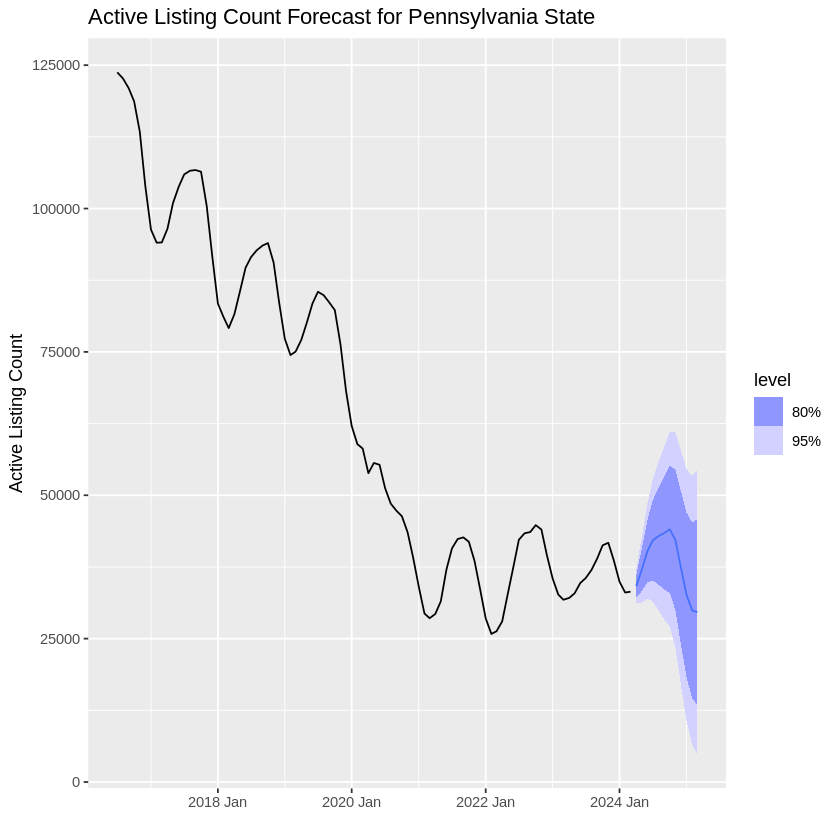

In [ ]:
pa_fnl |> forecast(h=12) |>
autoplot() +
autolayer(aggregated_pa_data, total_listing_pa) +
labs(title='Active Listing Count Forecast for Pennsylvania State', x='', y='Active Listing Count')

ARIMA performing well on Pennsylvania, suggests a slight increase in forecasts for next 12 months.

##For Delaware

In [ ]:
head(de_data)

month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,de,<aggregated>,7010
2016 Aug,de,<aggregated>,6972
2016 Sep,de,<aggregated>,6943
2016 Oct,de,<aggregated>,6911
2016 Nov,de,<aggregated>,6680
2016 Dec,de,<aggregated>,6177


In [ ]:
aggregated_de_data <- de_data %>%
fabletools::aggregate_key(
    state,
    total_listing_de=sum(total_listing)
)

aggregated_de_data %>% dim()

[1] 186   3

In [ ]:
aggregated_de_data %>% head()

month_date,state,total_listing_de
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,14020
2016 Aug,<aggregated>,13944
2016 Sep,<aggregated>,13886
2016 Oct,<aggregated>,13822
2016 Nov,<aggregated>,13360
2016 Dec,<aggregated>,12354


In [ ]:
library(dplyr)

# Filter out rows where county is "<aggregated>"
aggregated_de_data <- aggregated_de_data %>%
  filter(state != "<aggregated>")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


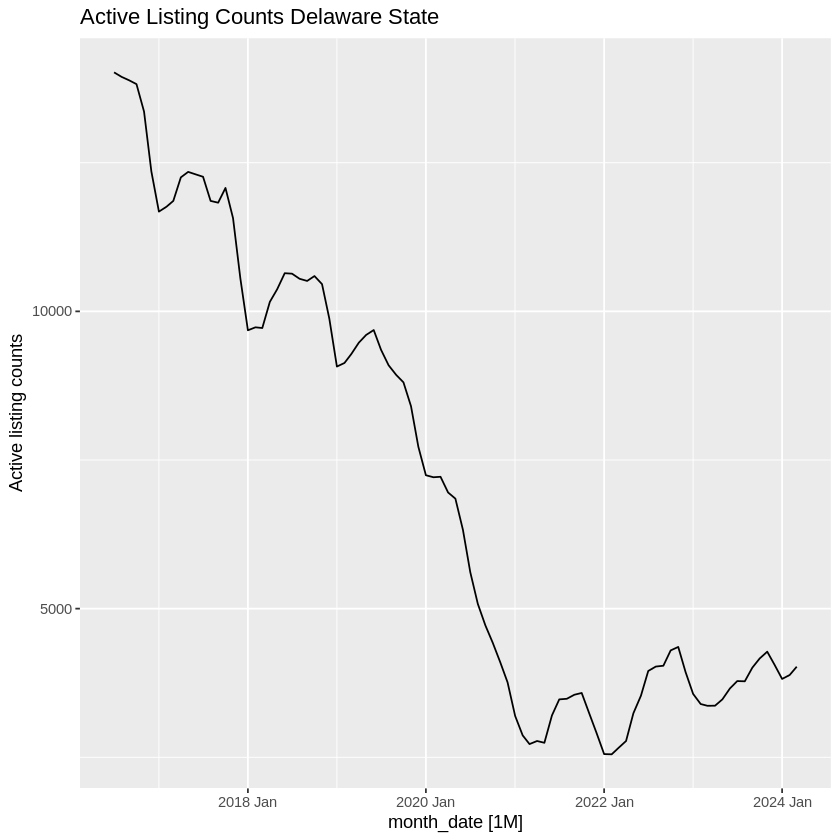

In [ ]:
aggregated_de_data |>
  autoplot(total_listing_de) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts Delaware State")

The overall trend is decreasing and the seasonality seems to break in between. After the middle of the year, there is spike in the values, the break is visible in every year.

In [ ]:
# Split data: training and testing
split_date <- as.Date("2022-12-01")
training_set_de <- aggregated_de_data %>% filter(month_date <= split_date)
testing_set_de <- aggregated_de_data %>% filter(month_date > split_date)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date <= split_date`.
Caused by warning:
! Incompatible methods ("<=.vctrs_vctr", "<=.Date") for "<="”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date > split_date`.
Caused by warning:
! Incompatible methods (">.vctrs_vctr", ">.Date") for ">"”


In [ ]:
# Fit models
models_de <- training_set_de %>%
  model(
    ARIMA = ARIMA(total_listing_de),
    ETS = ETS(total_listing_de),
    NAIVE = NAIVE(total_listing_de)
  )

models_de |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,199.7413,2.768512
ETS,208.8094,2.875389
NAIVE,361.8855,4.502324


ARIMA performs well on training set.

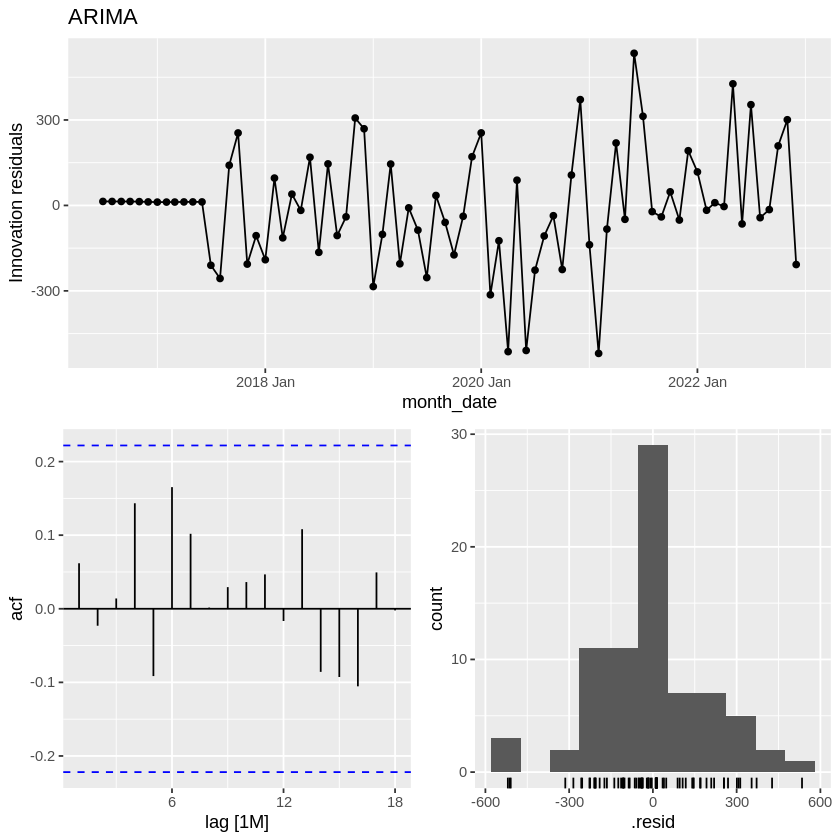

In [ ]:
models_de %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

The residuals look good as well, with no real pattern in the acf plots.

In [ ]:
de_fcst <- models_de |>
forecast(testing_set_de)

de_fcst |> accuracy(testing_set_de) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,419.5162,8.440094
ETS,831.0740,20.189967
NAIVE,328.2710,7.577924


Naive performs well on the testing set.

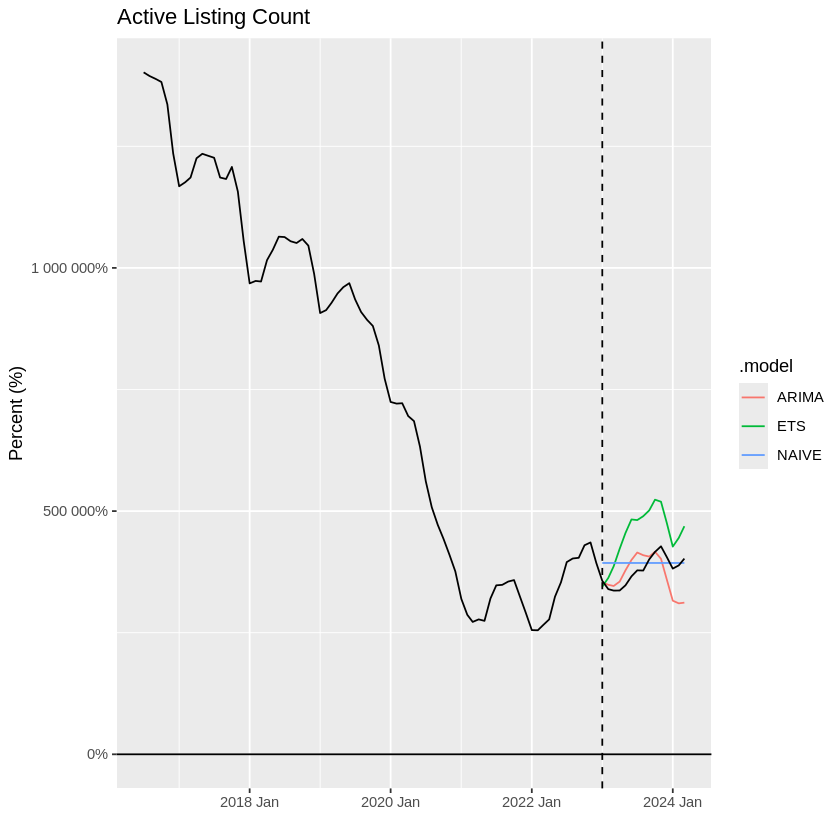

In [ ]:
de_fcst |> autoplot(level=NULL) +
autolayer(aggregated_de_data, total_listing_de) +
labs(title='Active Listing Count', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

According to the graph, the NAIVE fits well than the other models

In [ ]:
de_fnl <- aggregated_de_data |>
model(
    'NAIVE' = NAIVE(total_listing_de)
)

de_fnl %>% report()

Series: total_listing_de 
Model: NAIVE 

sigma^2: 103760.8887 


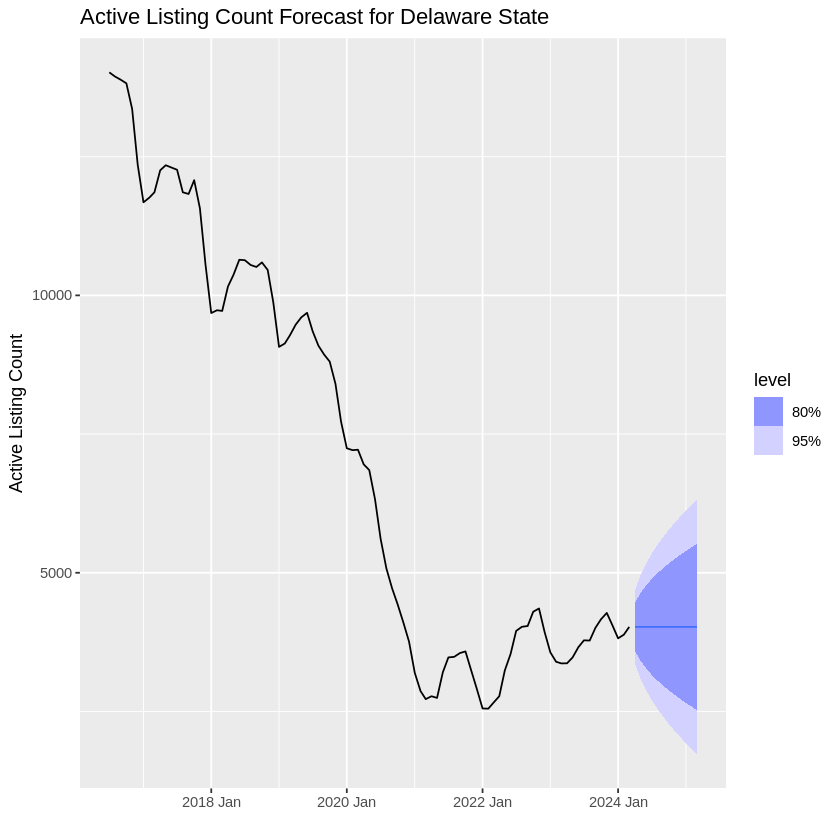

In [ ]:
de_fnl |> forecast(h=12) |>
autoplot() +
autolayer(aggregated_de_data, total_listing_de) +
labs(title='Active Listing Count Forecast for Delaware State', x='', y='Active Listing Count')

The values falling in the confidence intervals looks promising.

##For New Jersey

In [ ]:
head(nj_data)

month_date,state,county,total_listing
<mth>,<chr*>,<chr*>,<dbl>
2016 Jul,nj,<aggregated>,55374
2016 Aug,nj,<aggregated>,54138
2016 Sep,nj,<aggregated>,52809
2016 Oct,nj,<aggregated>,51213
2016 Nov,nj,<aggregated>,47680
2016 Dec,nj,<aggregated>,43518


In [ ]:
aggregated_nj_data <- nj_data %>%
fabletools::aggregate_key(
    state,
    total_listing_nj=sum(total_listing)
)

aggregated_nj_data %>% dim()
aggregated_nj_data %>% head()

[1] 186   3

month_date,state,total_listing_nj
<mth>,<chr*>,<dbl>
2016 Jul,<aggregated>,110748
2016 Aug,<aggregated>,108276
2016 Sep,<aggregated>,105618
2016 Oct,<aggregated>,102426
2016 Nov,<aggregated>,95360
2016 Dec,<aggregated>,87036


In [ ]:
library(dplyr)

# Filter out rows where county is "<aggregated>"
aggregated_nj_data <- aggregated_nj_data %>%
  filter(state != "<aggregated>")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `state != "<aggregated>"`.
Caused by warning:
! <aggregated> character values have been converted to aggregated values.
Hint: If you're trying to compare aggregated values, use `is_aggregated()`.”


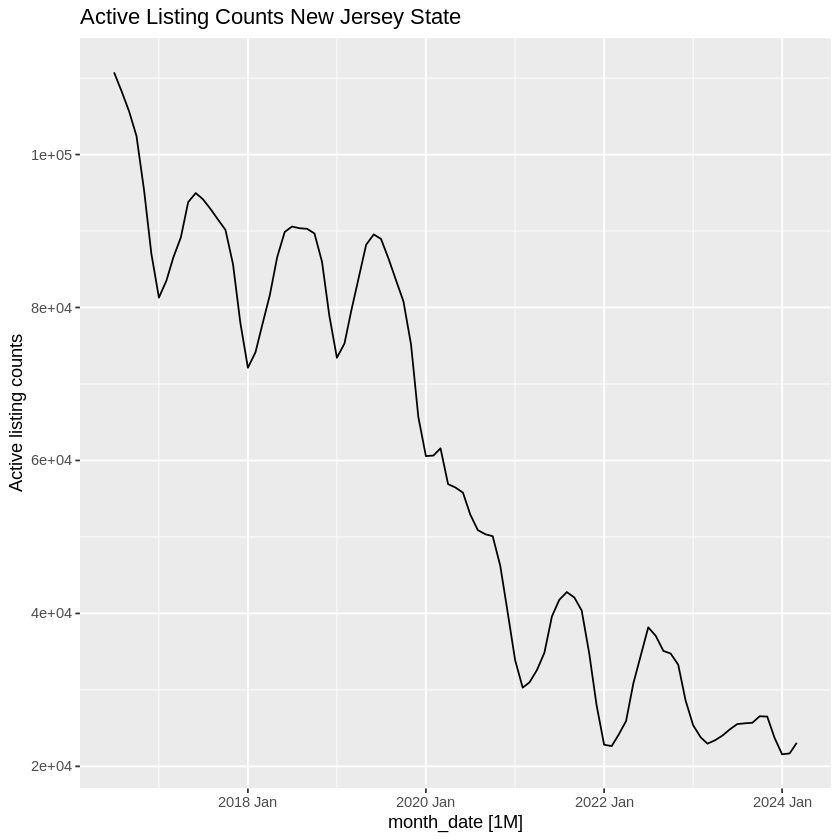

In [ ]:
aggregated_nj_data |>
  autoplot(total_listing_nj) +
  labs(y = "Active listing counts",
       title = "Active Listing Counts New Jersey State")

The trend is decreasing throughout the graph, the fall from 2019 seems a lot bigger compared to the other states. The values in 2023 seems very little compared to other states.

In [ ]:
# Split data: training and testing
split_date <- as.Date("2022-12-01")
training_set_nj <- aggregated_nj_data %>% filter(month_date <= split_date)
testing_set_nj <- aggregated_nj_data %>% filter(month_date > split_date)

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date <= split_date`.
Caused by warning:
! Incompatible methods ("<=.vctrs_vctr", "<=.Date") for "<="”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `month_date > split_date`.
Caused by warning:
! Incompatible methods (">.vctrs_vctr", ">.Date") for ">"”


In [ ]:
# Fit models
models_nj <- training_set_nj %>%
  model(
    ARIMA = ARIMA(total_listing_nj),
    ETS = ETS(total_listing_nj),
    NAIVE = NAIVE(total_listing_nj)
  )

models_nj |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,1362.770,1.980402
ETS,1639.513,2.484375
NAIVE,3782.200,5.699805


ARIMA performs well on training dataset.

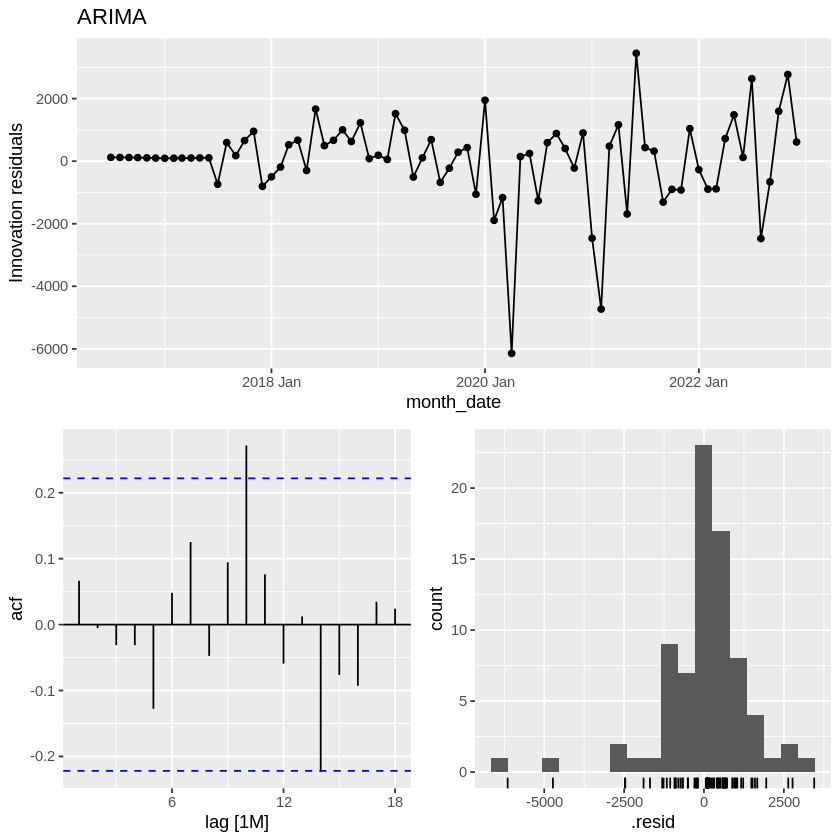

In [ ]:
models_nj %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

In [ ]:
nj_fcst <- models_nj |>
forecast(testing_set_nj)

nj_fcst |> accuracy(testing_set_nj) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,7245.257,26.56299
ETS,10029.780,36.01875
NAIVE,4604.539,18.34390


NAIVE performs well on the testing set, so I am using that for future forecasts

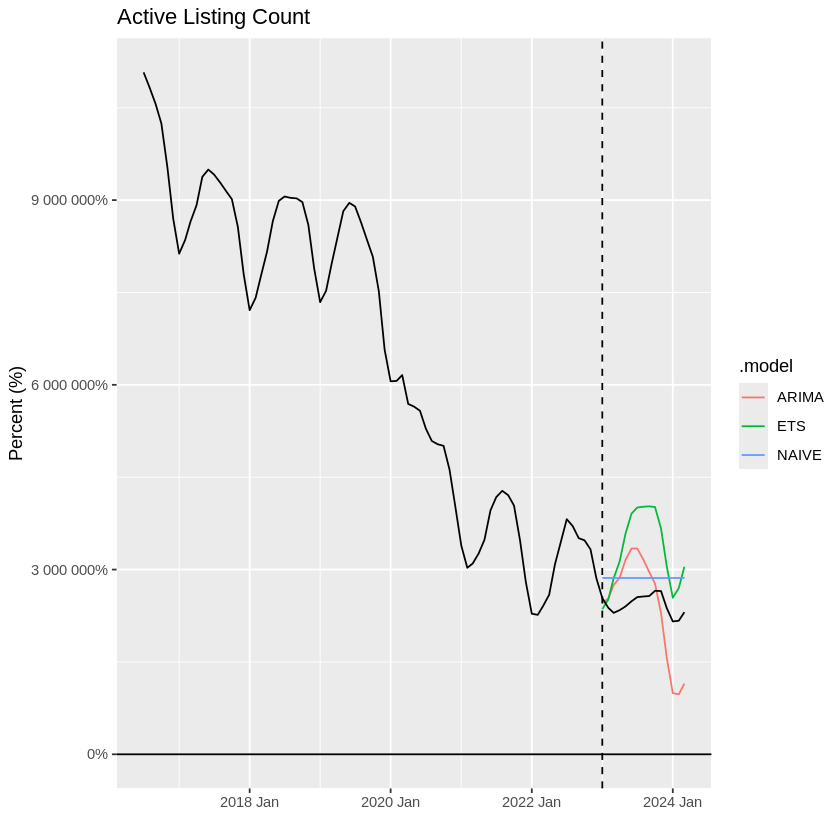

In [ ]:
nj_fcst |> autoplot(level=NULL) +
autolayer(aggregated_nj_data, total_listing_nj) +
labs(title='Active Listing Count', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

###Future forecatss

In [ ]:
nj_fnl <- aggregated_nj_data |>
model(
    'NAIVE' = NAIVE(total_listing_nj)
)

nj_fnl %>% report()

Series: total_listing_nj 
Model: NAIVE 

sigma^2: 11521623.4209 


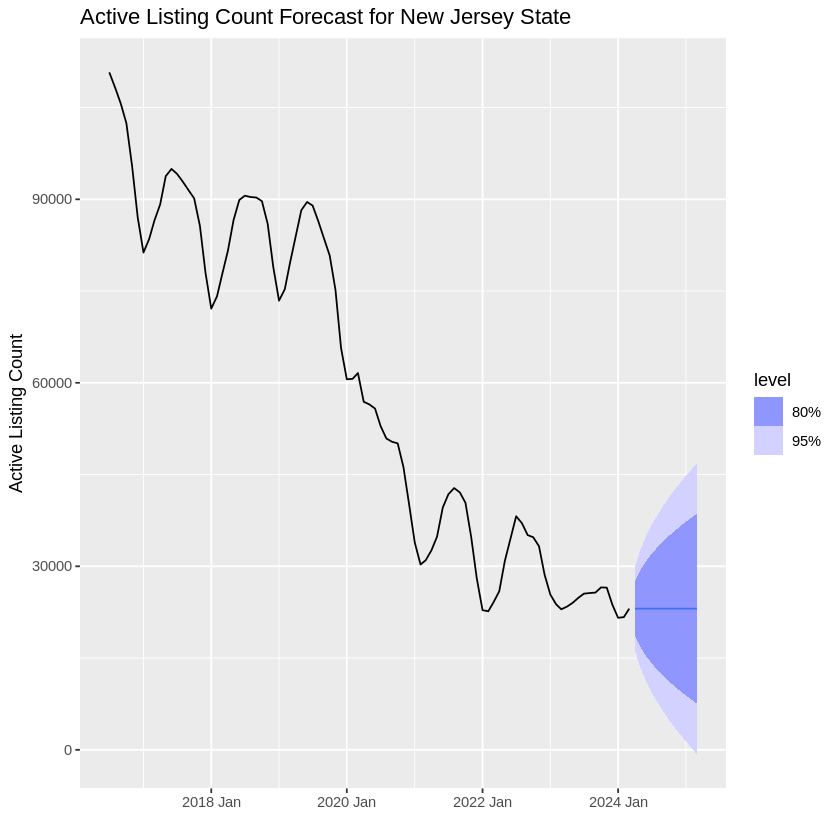

In [ ]:
nj_fnl |> forecast(h=12) |>
autoplot() +
autolayer(aggregated_nj_data, total_listing_nj) +
labs(title='Active Listing Count Forecast for New Jersey State', x='', y='Active Listing Count')

The confidence interval can capture the future forecasts well.

###Overall analysis

All the states show a decreasing trend with big drop from 2019 and then increase in 2021, but the data did not build up that much suggesting there are not many houses going on sale after the covid hit.

The most surprising thing is different models performing well on training and testing sets. I chose the one that performs well on testing set, because the model bases its performs well depending on the previous year.

###Possible improvements

I could have used Seasonal Naive to show the seasonal component best.